# Generative adversarial network (GAN)

## References
* Pytorch DCGAN Tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://github.com/christiancosgrove/pytorch-spectral-normalization-gan
* https://github.com/martinarjovsky/WassersteinGAN

## Papers
* Vanilla GAN by [Goodfellow et al.](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)
* Deep Convolutional GAN by [Radford et al.](https://arxiv.org/pdf/1511.06434.pdf)
* Spectral Normalization GAN by [Miyato et al.](https://openreview.net/pdf?id=B1QRgziT-)
* Fréchet Inception Distance (FID) score [Heusel et al.](https://arxiv.org/pdf/1706.08500.pdf)

## 0. Preliminary

### 0.0 Packages and GPU setup

In [3]:
!nvidia-smi

Sun Oct 18 16:31:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8    N/A /  N/A |    284MiB /  2002MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import os
import random

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [32]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio  #### install with "pip install imageio"
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid

from spectral_norm import SpectralNorm

In [3]:
# Create folders
if not os.path.exists("./checkpoint"):
    os.mkdir("./checkpoint")

if not os.path.exists("./celeba"):
    os.mkdir("./celeba")

if not os.path.exists("./img"):
    os.mkdir("./img")

if not os.path.exists("./img/real"):
    os.mkdir("./img/real")

if not os.path.exists("./img/fake"):
    os.mkdir("./img/fake")

### 0.1 Download datasets
Celeba dataset may be obtained from pytorch dataset libraries/ google drive from [here](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg)/ s3 database from [udacity](https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip). In this exercise, we will download the dataset from udacity s3 server for easier implementation using google colab.  

In [1]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2020-10-18 16:17:31--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.48
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  2.33MB/s    in 12m 16s 

2020-10-18 16:29:48 (1.87 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
!unzip celeba.zip -d celeba

In [4]:
# Check the number of images
import os

root = "celeba/img_align_celeba"
img_list = os.listdir(root)
print(len(img_list))  # This should be 202599

202599


### 0.2 Load Hyperparameters

In [5]:
# Root directory for dataset
dataroot = "celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

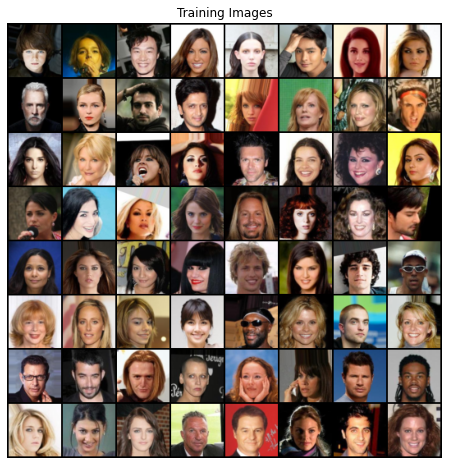

In [6]:
# Load and display dataset
dataset = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

## 1. Define Generator and Discriminator

### 1.0 Weight Initialization

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 1.1 Generator
Note that if you want to train from checkpoint, weight initialization is not necessary. (For both generator and discriminator)

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == "cuda") and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 1.2 Discriminator
Since we are going to implement Spectral Normalization on Discriminator (netD), we will have different setup for netD from DCGAN which is: <br> 
```python
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)
```

In [34]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            SpectralNorm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            SpectralNorm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            SpectralNorm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [36]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == "cuda") and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): SpectralNorm(
      (module): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): SpectralNorm(
      (module): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    )
    (9): Sigmoid()
  )
)


### 1.3 Optimizer, Fixed Noise, Exponential decay lr, Loss function, Lables
For DCGAN, optimizerD should be <br>
```python
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) 
```

In [38]:
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(
    filter(lambda p: p.requires_grad, netD.parameters()), lr=lr, betas=(beta1, 0.9)
)

In [41]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

scheduler_d = optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)
scheduler_g = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)

criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

## 2. Training

### 2.0 Train from checkpoint (Optional)

In [ ]:
# Train from checkpoint
checkpointD = torch.load(
    "./checkpoint/netD_epoch_20.pth", map_location=torch.device("cuda")
)
checkpointG = torch.load(
    "./checkpoint/netG_epoch_20.pth", map_location=torch.device("cuda")
)

# checkpoint = torch.load("./checkpoint/model_final.pth", map_location=torch.device("cuda"))

netG.load_state_dict(checkpointG)
netD.load_state_dict(checkpointD)

# netG.load_state_dict(checkpoint["generator"])
# netD.load_state_dict(checkpoint["discriminator"])

# optimizerG.load_state_dict(checkpoint['optimizerG'])
# optimizerD.load_state_dict(checkpoint['optimizerD'])

netG.train()
netD.train()

### 2.1 Train from start

In [42]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print(f"Using device: {device}")
print("Starting Training Loop...")
for epoch in range(num_epochs + 1):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(dataloader),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    scheduler_d.step()
    scheduler_g.step()

    # Check pointing for every epoch
    torch.save(netG.state_dict(), "./checkpoint/netG_epoch_%d.pth" % (epoch))
    torch.save(netD.state_dict(), "./checkpoint/netD_epoch_%d.pth" % (epoch))

torch.save(
    {
        "generator": netG.state_dict(),
        "discriminator": netD.state_dict(),
        "optimizerG": optimizerG.state_dict(),
        "optimizerD": optimizerD.state_dict(),
    },
    "./checkpoint/model_final.pth",
)

Using device: cuda:0
Starting Training Loop...
[0/20][0/1583]	Loss_D: 1.3678	Loss_G: 0.6371	D(x): 0.5121	D(G(z)): 0.5026 / 0.5288
[0/20][50/1583]	Loss_D: 0.7683	Loss_G: 0.9210	D(x): 0.9259	D(G(z)): 0.4787 / 0.3982
[0/20][100/1583]	Loss_D: 0.8611	Loss_G: 0.6595	D(x): 0.8512	D(G(z)): 0.4900 / 0.5173
[0/20][150/1583]	Loss_D: 0.8713	Loss_G: 0.7760	D(x): 0.8788	D(G(z)): 0.5069 / 0.4603
[0/20][200/1583]	Loss_D: 1.1572	Loss_G: 0.6180	D(x): 0.7872	D(G(z)): 0.5845 / 0.5417
[0/20][250/1583]	Loss_D: 1.0399	Loss_G: 0.7170	D(x): 0.8431	D(G(z)): 0.5582 / 0.4991
[0/20][300/1583]	Loss_D: 1.2207	Loss_G: 0.6635	D(x): 0.7315	D(G(z)): 0.5839 / 0.5185
[0/20][350/1583]	Loss_D: 1.2444	Loss_G: 0.7458	D(x): 0.7920	D(G(z)): 0.6267 / 0.4761
[0/20][400/1583]	Loss_D: 1.1136	Loss_G: 0.7298	D(x): 0.7416	D(G(z)): 0.5478 / 0.4837
[0/20][450/1583]	Loss_D: 1.2369	Loss_G: 0.6386	D(x): 0.7198	D(G(z)): 0.5881 / 0.5300
[0/20][500/1583]	Loss_D: 1.1456	Loss_G: 0.8041	D(x): 0.7704	D(G(z)): 0.5760 / 0.4514
[0/20][550/1583]	Loss

KeyboardInterrupt: 

## 3. Visualise Results/ Graphs

### 3.0 Generator and Discriminator Loss Graphs

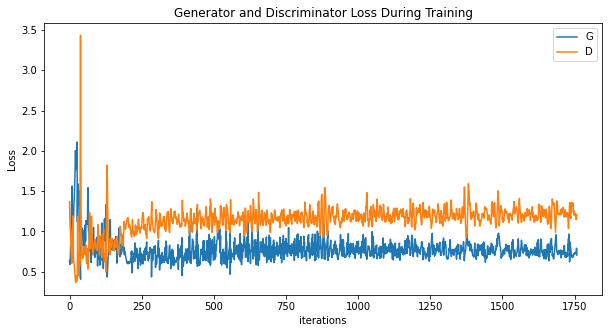

In [43]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 3.1 Display Real and Fake Images

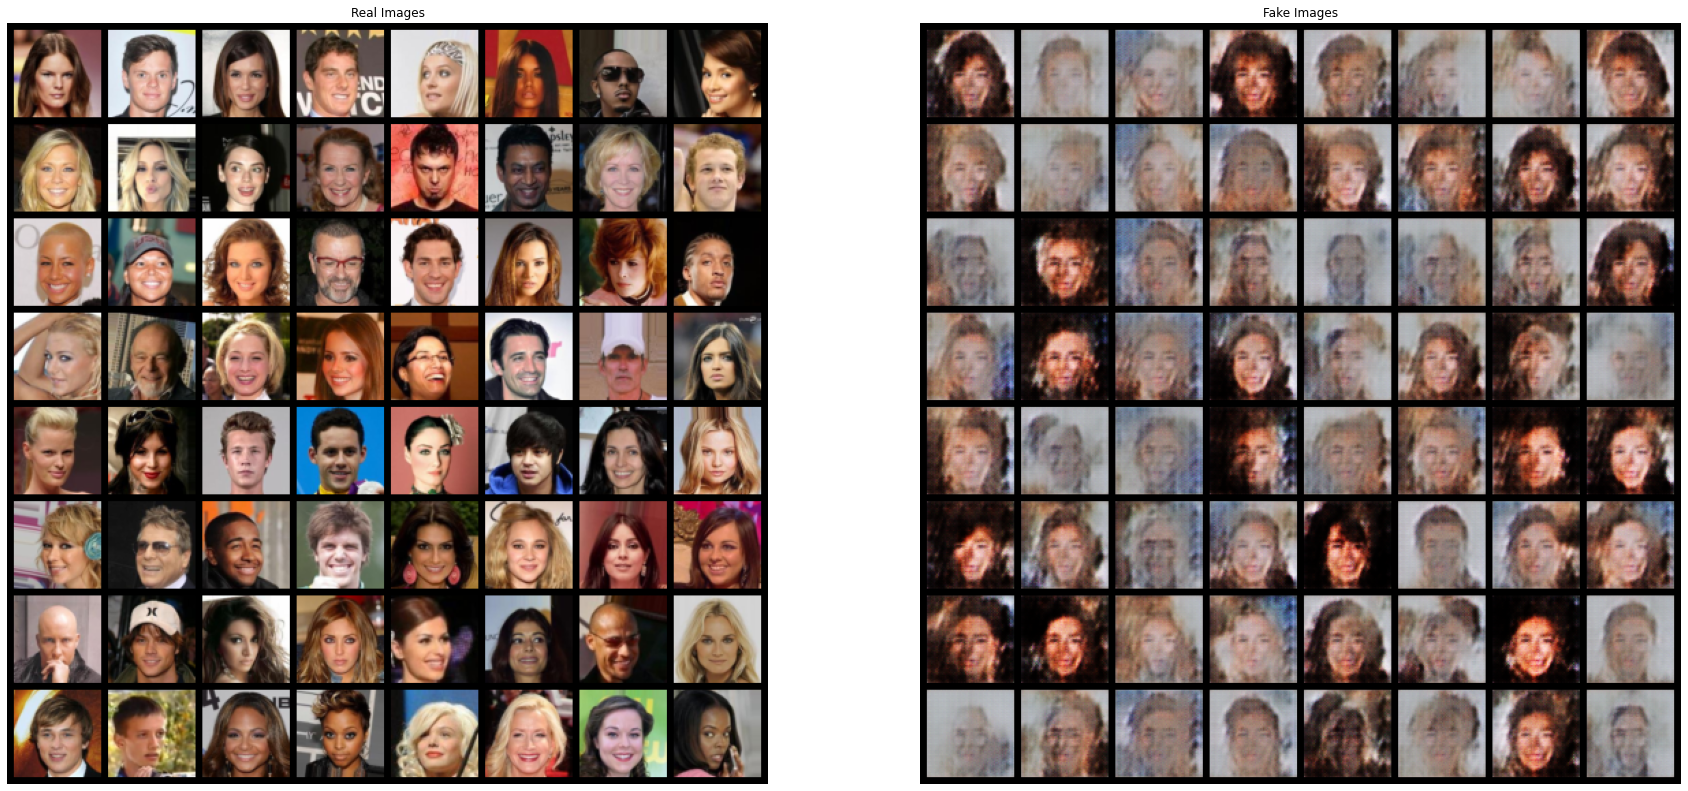

In [44]:
fakelist = []

with torch.no_grad():
    noise = torch.randn(64, nz, 1, 1, device=device)
    fake_dataset = netG(noise).detach().cpu()
    fakelist.append(vutils.make_grid(fake_dataset, padding=5, normalize=True))

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(30, 30))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=5, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fakelist[-1], (1, 2, 0)))
plt.show()

## 4. Evaluate Using FID Score
Note that Inception network is pretrained on ImageNet, therefore the CelebA FID score might be unrealiable.

### 4.0 Download FID Score function code 
From [github](https://github.com/mseitzer/pytorch-fid) / [pip package](https://pypi.org/project/pytorch-fid/).

In [45]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg' -O inception.py

--2020-10-18 18:14:06--  https://docs.google.com/uc?export=download&id=1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg
Resolving docs.google.com (docs.google.com)... 2404:6800:4001:807::200e, 172.217.31.46
Connecting to docs.google.com (docs.google.com)|2404:6800:4001:807::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lu83niupoghmenhmc3mnes9inr9r81iv/1603016025000/05323530314538631540/*/1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg?e=download [following]
--2020-10-18 18:14:07--  https://doc-0k-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lu83niupoghmenhmc3mnes9inr9r81iv/1603016025000/05323530314538631540/*/1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg?e=download
Resolving doc-0k-6s-docs.googleusercontent.com (doc-0k-6s-docs.googleusercontent.com)... 2404:6800:4001:802::2001, 172.217.24.161
Connecting to doc-0k-6s-docs.googleusercontent.com (doc-0k-6s-d

In [46]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AtTxnuasIaSTTmI9MI7k8ugY8KJ1cw3Y' -O fid_score.py

--2020-10-18 18:14:07--  https://docs.google.com/uc?export=download&id=1AtTxnuasIaSTTmI9MI7k8ugY8KJ1cw3Y
Resolving docs.google.com (docs.google.com)... 2404:6800:4001:807::200e, 172.217.31.46
Connecting to docs.google.com (docs.google.com)|2404:6800:4001:807::200e|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i83q1pbnn95r2hejgkrimit03pnk719n/1603016025000/05323530314538631540/*/1AtTxnuasIaSTTmI9MI7k8ugY8KJ1cw3Y?e=download [following]
--2020-10-18 18:14:08--  https://doc-08-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i83q1pbnn95r2hejgkrimit03pnk719n/1603016025000/05323530314538631540/*/1AtTxnuasIaSTTmI9MI7k8ugY8KJ1cw3Y?e=download
Resolving doc-08-6s-docs.googleusercontent.com (doc-08-6s-docs.googleusercontent.com)... 2404:6800:4001:802::2001, 172.217.24.161
Connecting to doc-08-6s-docs.googleusercontent.com (doc-08-6s-d

### 4.1 Generate Real and Fake Images

In [47]:
def save_image_list(dataset, real):
    if real:
        base_path = "./img/real"
    else:
        base_path = "./img/fake"

    dataset_path = []

    for i in range(len(dataset)):
        save_path = f"{base_path}/image_{i}.png"
        dataset_path.append(save_path)
        vutils.save_image(dataset[i], save_path, normalize=True)

    return base_path

In [48]:
# generate fake images
with torch.no_grad():
    noise = torch.randn(50, nz, 1, 1, device=device)
    fake_dataset = netG(noise).detach().cpu()
    fake_image_path_list = save_image_list(fake_dataset, False)

    # true images
    test_dataset = dset.ImageFolder(
        root="./celeba",
        transform=transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )

    dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=50, shuffle=True, num_workers=2
    )

    for i, (data, _) in enumerate(dataloader):
        real_dataset = data
        break

    real_image_path_list = save_image_list(real_dataset, True)

In [49]:
from fid_score import calculate_fid_given_paths

fid_value = calculate_fid_given_paths(
    [real_image_path_list, fake_image_path_list], 50, False, 2048
)

print(f"FID score: {fid_value}")

FID score: 338.69486045503874
